#### Problem Statement

* Build a machine learning model(s) that could predict the output of the food processing farms for the next year

#### Problem Description

* A new fast food chain is seeing rapid expansion over the past couple of years. They 
are now trying to optimize their supply chain to ensure that there are no shortages of  
ingredients.  For this, they’ve tasked their data science team to come up with a mod-
el that could predict the output of each food processing farm over the next few years. 
These predictions could further increase the efﬁciency of their current supply chain 
management systems.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Loading the required Libraries

In [2]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt
from IPython.display import Image
from pylab import rcParams
from matplotlib import rc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 7

import tensorflow as tf
from tensorflow import keras

RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
# To filter warnings
import warnings 
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### Loading Train

In [ ]:
train_data = pd.read_csv("train_data.csv")
farm_data = pd.read_csv("farm_data.csv")
train_weather = pd.read_csv("train_weather.csv")
#train_data = pd.read_csv("/content/drive/MyDrive/PHD/train_data.csv")
#farm_data = pd.read_csv("/content/drive/MyDrive/PHD/farm_data.csv")
#train_weather = pd.read_csv("/content/drive/MyDrive/PHD/train_weather.csv")

In [5]:
print(train_data.shape)
print(farm_data.shape)
print(train_weather.shape)

(20216100, 4)
(1449, 6)
(139773, 9)


In [6]:
train_data.duplicated().sum()

117

In [7]:
train_data.drop_duplicates(inplace=True)
train_data.duplicated().sum()

0

In [8]:
print(farm_data.duplicated().sum())
print(train_weather.duplicated().sum())


0
0


In [9]:
train_data.head()

,date,farm_id,ingredient_type,yield
0,2016-01-01 00:00:00,fid_110884,ing_w,0.0
1,2016-01-01 00:00:00,fid_90053,ing_w,0.0
2,2016-01-01 00:00:00,fid_17537,ing_w,0.0
3,2016-01-01 00:00:00,fid_110392,ing_w,0.0
4,2016-01-01 00:00:00,fid_62402,ing_w,0.0


In [10]:
train_data.tail()

,date,farm_id,ingredient_type,yield
20216095,2016-12-31 23:00:00,fid_41664,ing_w,8.750
20216096,2016-12-31 23:00:00,fid_14529,ing_w,4.825
20216097,2016-12-31 23:00:00,fid_46454,ing_w,0.000
20216098,2016-12-31 23:00:00,fid_24103,ing_w,159.575
20216099,2016-12-31 23:00:00,fid_34139,ing_w,2.850


In [11]:
farm_data.head()

,farm_id,operations_commencing_year,num_processing_plants,farm_area,farming_company,deidentified_location
0,fid_110884,2008.0,NaN,690.455096,Obery Farms,location 7369
1,fid_90053,2004.0,NaN,252.696160,Obery Farms,location 7369
2,fid_17537,1991.0,NaN,499.446528,Obery Farms,location 7369
3,fid_110392,2002.0,NaN,2200.407555,Obery Farms,location 7369
4,fid_62402,1975.0,NaN,10833.140121,Obery Farms,location 7369


In [12]:
train_weather.head()

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2016-01-01 00:00:00,location 7369,25.0,6.0,0.0,20.0,1019.7,NaN,0.0
1,2016-01-01 01:00:00,location 7369,24.4,NaN,70.0,21.1,1020.2,-1.0,1.5
2,2016-01-01 02:00:00,location 7369,22.8,2.0,0.0,21.1,1020.2,0.0,0.0
3,2016-01-01 03:00:00,location 7369,21.1,2.0,0.0,20.6,1020.1,0.0,0.0
4,2016-01-01 04:00:00,location 7369,20.0,2.0,250.0,20.0,1020.0,-1.0,2.6


In [13]:
print(len(train_data['farm_id'].value_counts()))
print(len(farm_data['farm_id'].value_counts()))

1434
1434


In [2]:
def understand_data(data) :
    return(pd.DataFrame({"Datatype":data.dtypes,
                         "No of NAs":data.isna().sum(),
                         "No of Levels":data.apply(lambda x: x.nunique(),axis=0),
                         "Levels":data.apply(lambda x: str(x.unique()),axis=0)}))

In [15]:
understand_data(train_data)

,Datatype,No of NAs,No of Levels,Levels
date,object,0,8784,['2016-01-01 00:00:00' '2016-01-01 01:00:00' '...
farm_id,object,0,1434,['fid_110884' 'fid_90053' 'fid_17537' ... 'fid...
ingredient_type,object,0,4,['ing_w' 'ing_z' 'ing_x' 'ing_y']
yield,float64,0,1688175,[ 0. 53.2397 43.0013 ... 3006.82 ...


In [16]:
#train_report = ProfileReport(train_data,explorative=True)

In [17]:
#train_report.to_file("train_report.html")

In [18]:
farm_data.shape

(1449, 6)

In [19]:
understand_data(farm_data)

,Datatype,No of NAs,No of Levels,Levels
farm_id,object,0,1434,['fid_110884' 'fid_90053' 'fid_17537' ... 'fid...
operations_commencing_year,float64,774,116,[2008. 2004. 1991. 2002. 1975. 2000. 1981. 198...
num_processing_plants,float64,1094,18,[nan 9. 8. 14. 10. 12. 11. 13. 17. 20. 15. 1...
farm_area,float64,0,1397,[ 690.455096 252.69616 499.446528 ... 1046....
farming_company,object,0,16,['Obery Farms' 'Dole Food Company' 'Wayne Farm...
deidentified_location,object,0,16,['location 7369' 'location 959' 'location 5489...


In [20]:
#farm_report = ProfileReport(farm_data,explorative=True)

In [21]:
#farm_report.to_file("farm_report.html")

In [22]:
understand_data(train_weather)

,Datatype,No of NAs,No of Levels,Levels
timestamp,object,0,8784,['2016-01-01 00:00:00' '2016-01-01 01:00:00' '...
deidentified_location,object,0,16,['location 7369' 'location 959' 'location 5489...
temp_obs,float64,55,619,[ 25. 24.4 22.8 21.1 20. 19.4 20.6 18...
cloudiness,float64,69173,10,[ 6. nan 2. 4. 8. 0. 9. 7. 5. 3. 1.]
wind_direction,float64,6268,43,[ 0. 70. 250. 210. 290. 230. 200. 180. 220. ...
dew_temp,float64,113,522,[ 20. 21.1 20.6 19.4 18.9 18.3 17.8 17...
pressure_sea_level,float64,10618,709,[1019.7 1020.2 1020.1 1020. nan 1019.4 101...
precipitation,float64,50289,128,[ nan -1. 0. 3. 5. 8. 2. 10. 20. ...
wind_speed,float64,304,58,[ 0. 1.5 2.6 3.1 4.1 3.6 5.1 4.6 2.1 ...


In [23]:
#weather_report = ProfileReport(train_weather,explorative=True)

In [24]:
#weather_report.to_file("weather_report.html")

#### Observations
* "farm_id" has a high cardinality: 1434 distinct values
* operations_commencing_year has 774 (53.4%) missing values
* num_processing_plants has 1094 (75.5%) missing values
* cloudiness has 69173 (49.5%) missing values
* precipitation has 50289 (36.0%) missing values
* cloudiness has 33871 (24.2%) zeros
* precipitation has 77910 (55.7%) zeros

#### Feature Engineering

In [25]:
train_data["date"] = pd.to_datetime(train_data["date"], format = '%Y-%m-%d %H:%M:%S')
train_data["month"] = pd.to_datetime(train_data["date"], format = '%Y-%m-%d %H:%M:%S').dt.month
train_data["Day"] = pd.to_datetime(train_data["date"], format = '%Y-%m-%d %H:%M:%S').dt.day
train_data["Hour"] = pd.to_datetime(train_data["date"], format = '%Y-%m-%d %H:%M:%S').dt.hour

In [26]:
train_data.head()

,date,farm_id,ingredient_type,yield,month,Day,Hour
0,2016-01-01,fid_110884,ing_w,0.0,1,1,0
1,2016-01-01,fid_90053,ing_w,0.0,1,1,0
2,2016-01-01,fid_17537,ing_w,0.0,1,1,0
3,2016-01-01,fid_110392,ing_w,0.0,1,1,0
4,2016-01-01,fid_62402,ing_w,0.0,1,1,0


**Data Exploration and Visualization**

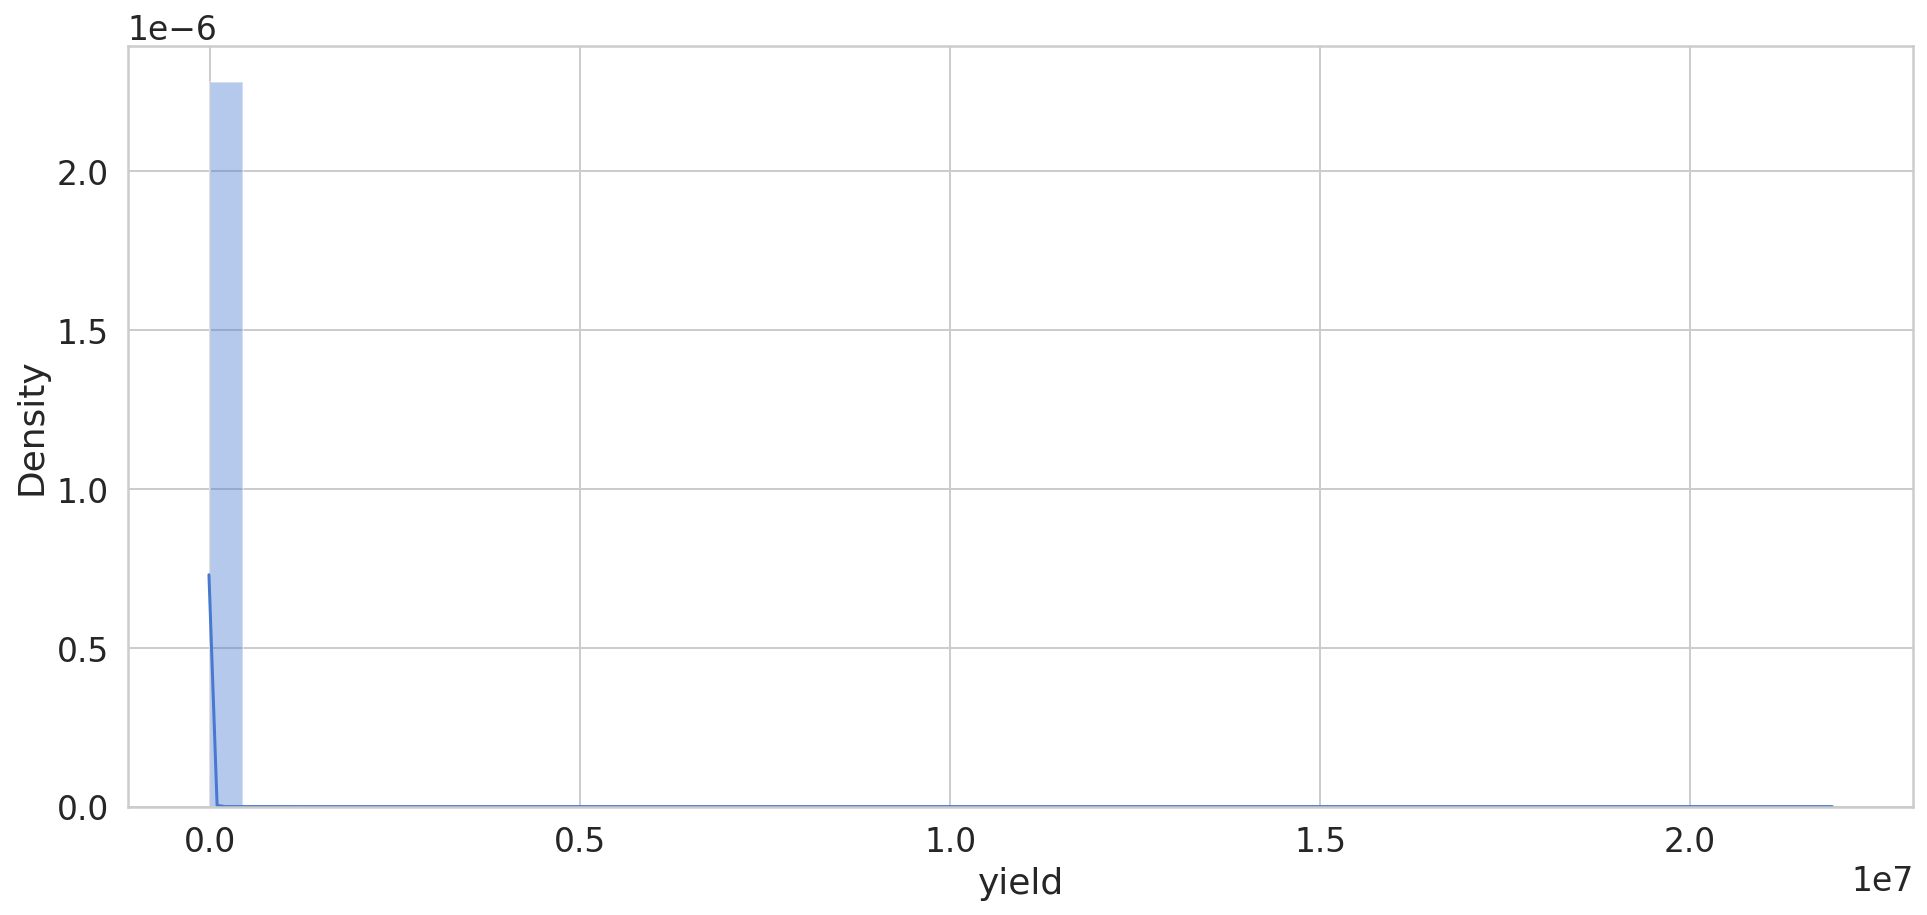

In [ ]:
sns.distplot(train_data["yield"])

#### Observations
* Target variable(yield) is highly skewed (γ1 = 104.8110103)
* yield has 1873868 (9.3%) zeros

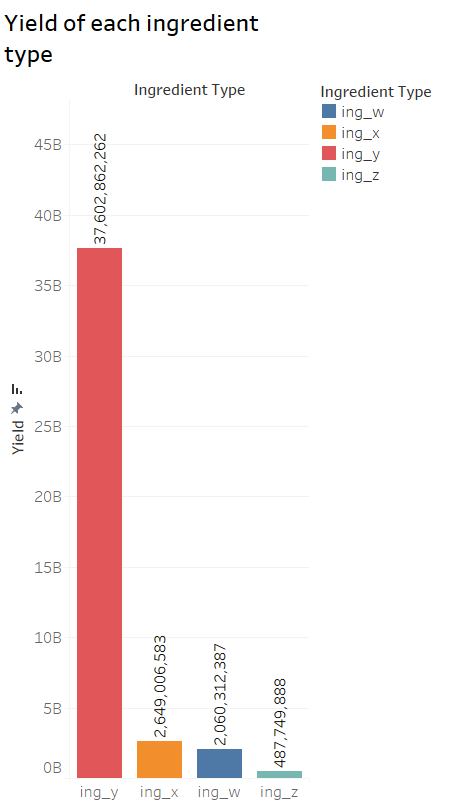

In [3]:
Image(r'C:\Users\Raj\OneDrive\Desktop\PHD\Tablue\Sheet 1.png')

#### Observation
* ing_y has more yield compared to other ingredients types.

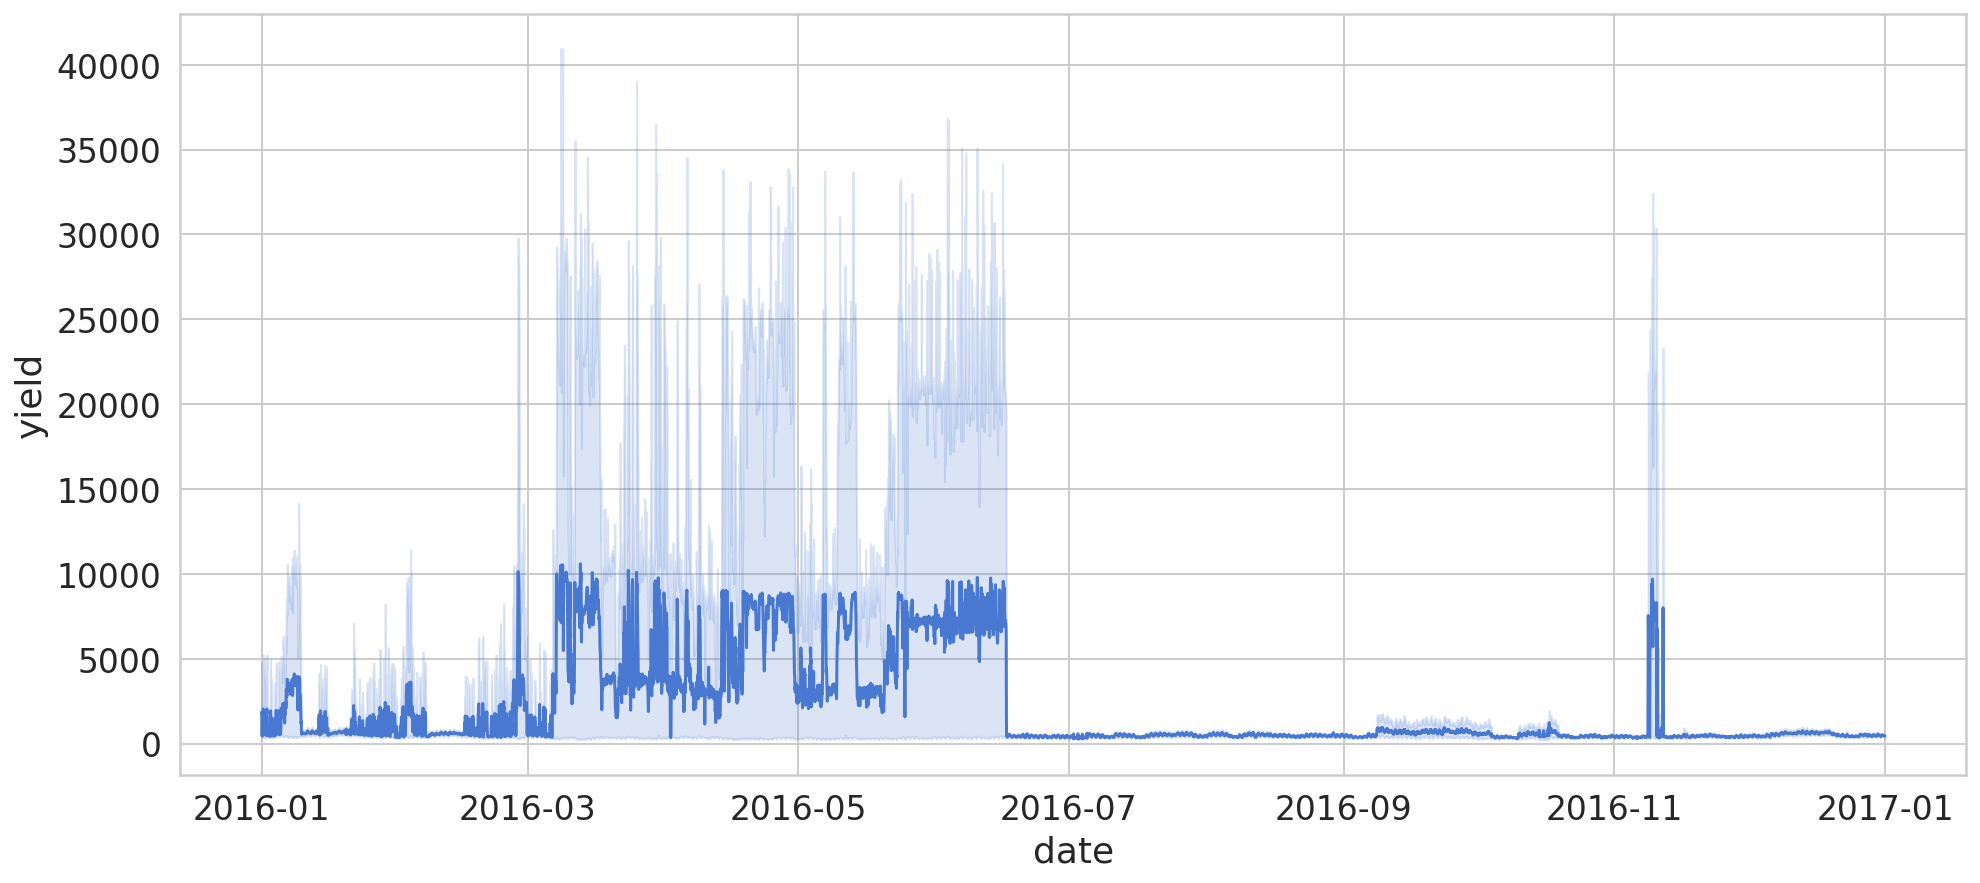

In [ ]:
sns.lineplot(x=train_data['date'], y='yield', data=train_data)

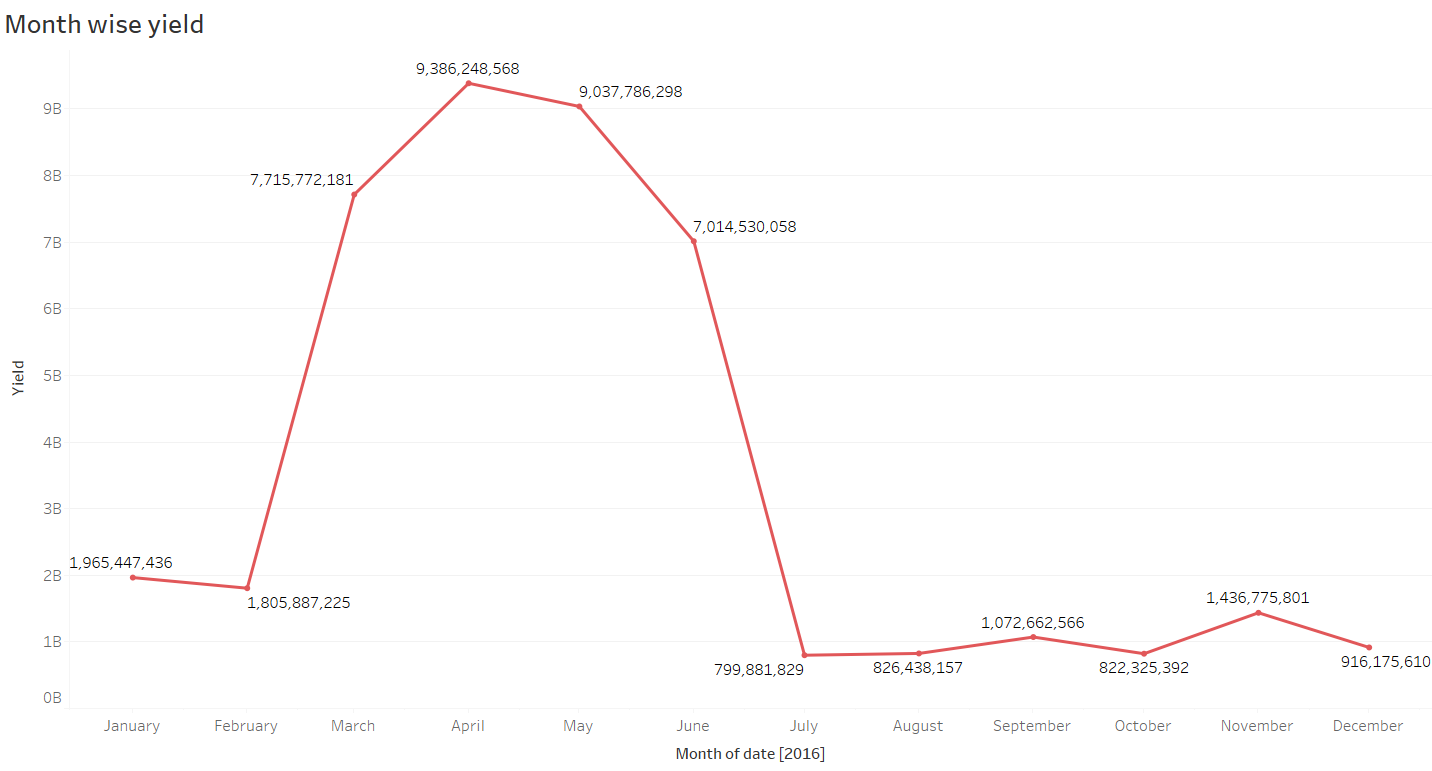

In [4]:
Image(r'C:\Users\Raj\OneDrive\Desktop\PHD\Tablue\Sheet 2.png')

#### Observation
* Data seems to have a strong seasonality component, More yield in the month of "March","April","May","June" 

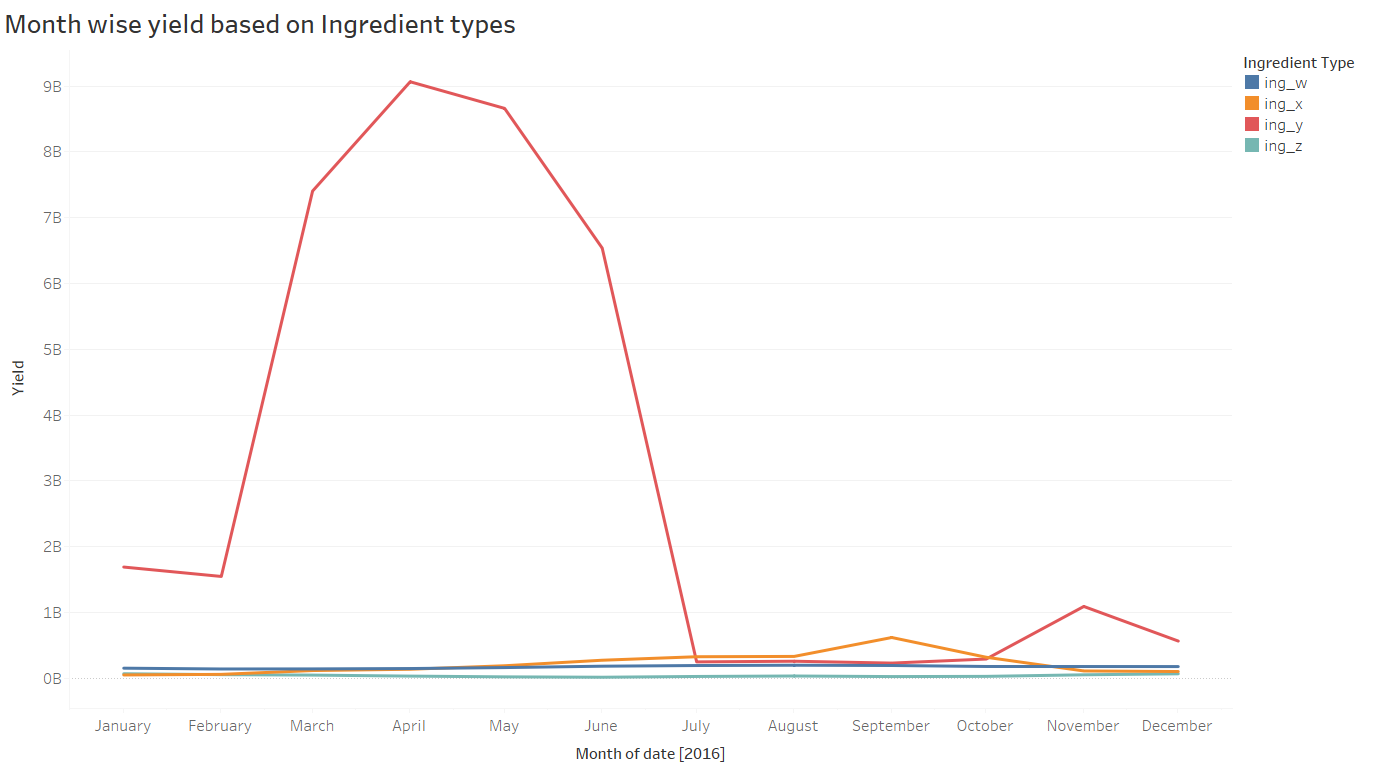

In [5]:
Image(r'C:\Users\Raj\OneDrive\Desktop\PHD\Tablue\Sheet 3.png')

#### Observation
* yield of "ing_y" more in the months of March to July compared to other type of ingrediants
* ing_y dominating more remove the ing_y and analyze other ingrediant types

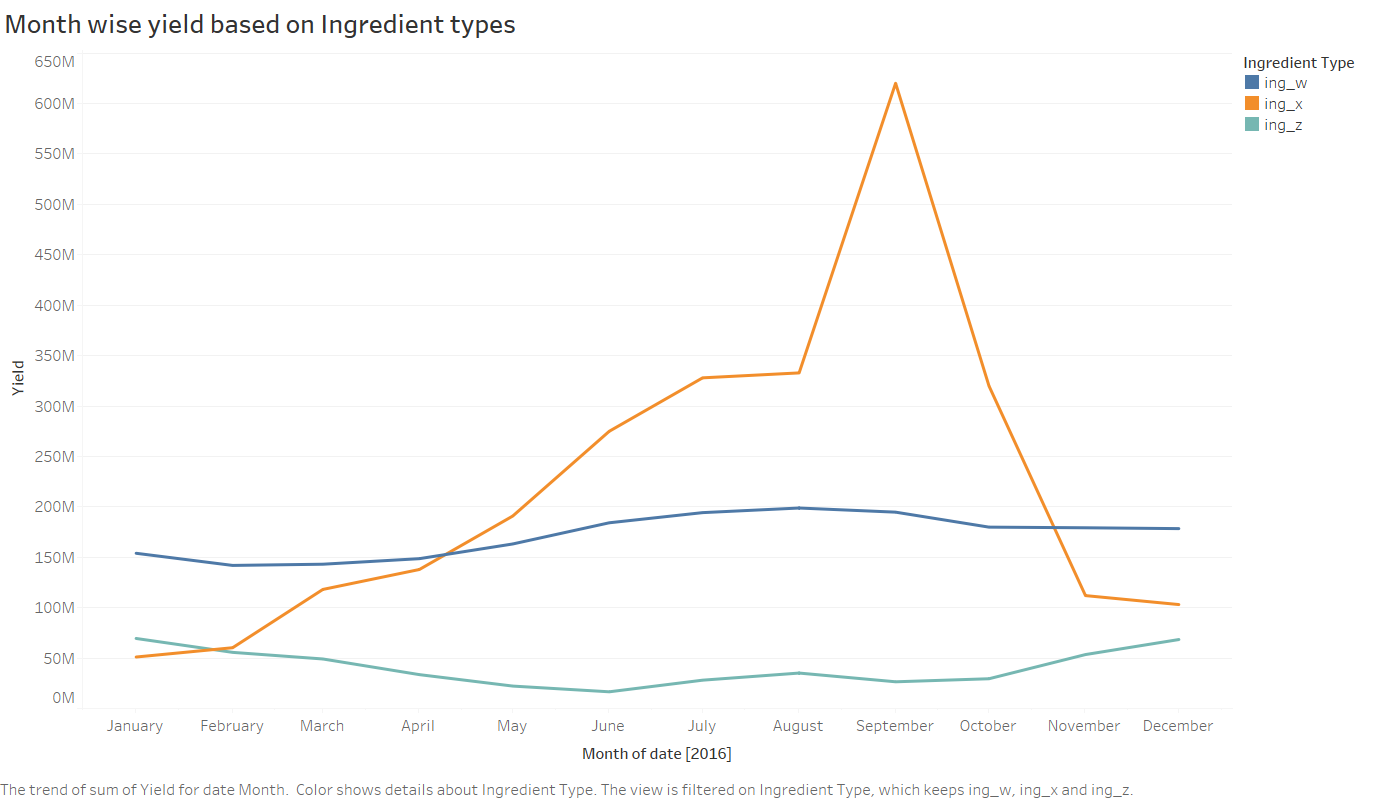

In [6]:
Image(r'C:\Users\Raj\OneDrive\Desktop\PHD\Tablue\Sheet 4.png')

#### Observation
* yield of "ing_w and "ing_z" is almost constant through out year
* yield of ing_x more in the of september

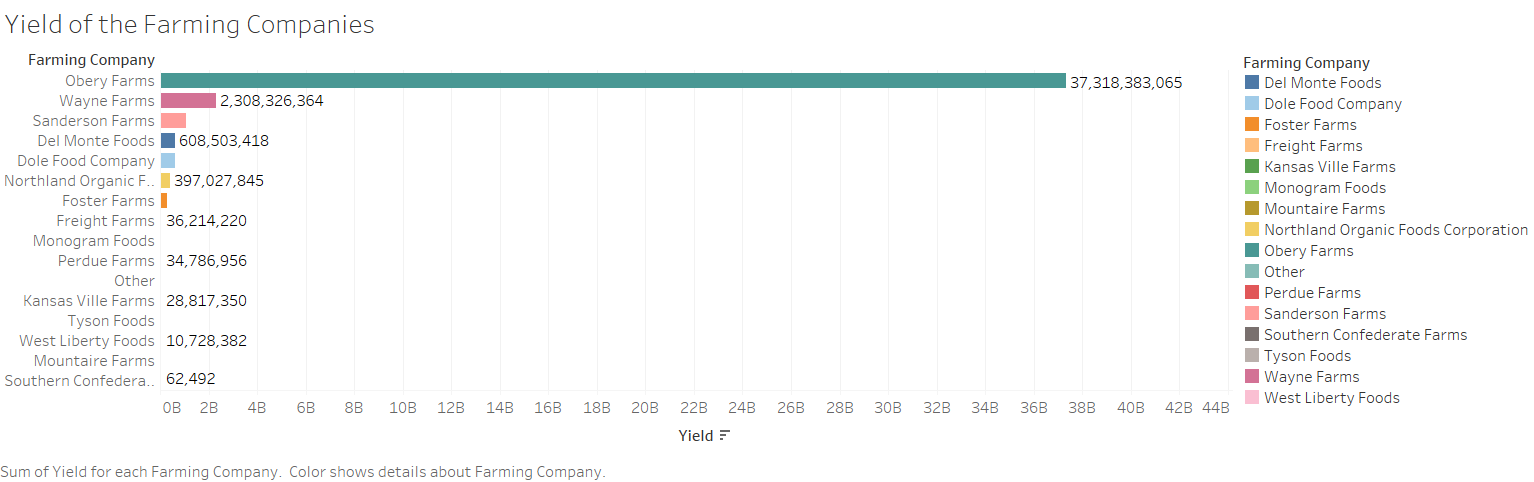

In [7]:
Image(r'C:\Users\Raj\OneDrive\Desktop\PHD\Tablue\Sheet 5.png')

#### Obsevations
* yield of Obey farms farming company is more comapred to other farming company

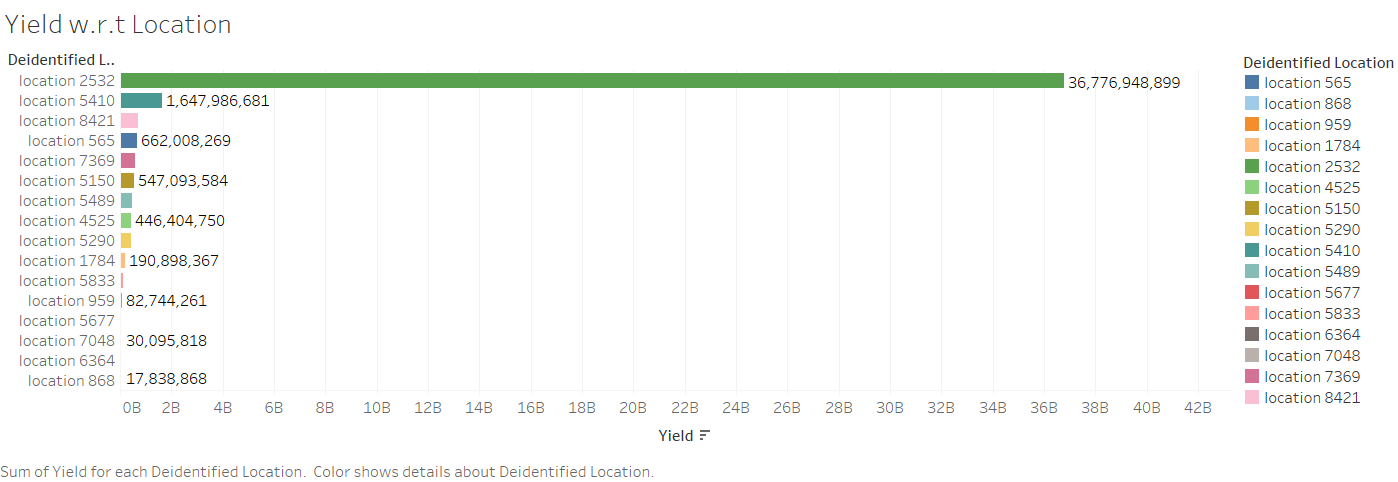

In [8]:
Image(r'C:\Users\Raj\OneDrive\Desktop\PHD\Tablue\Sheet 6.png')

#### Obsevation
* Most fo the yield coming from the "location2532"

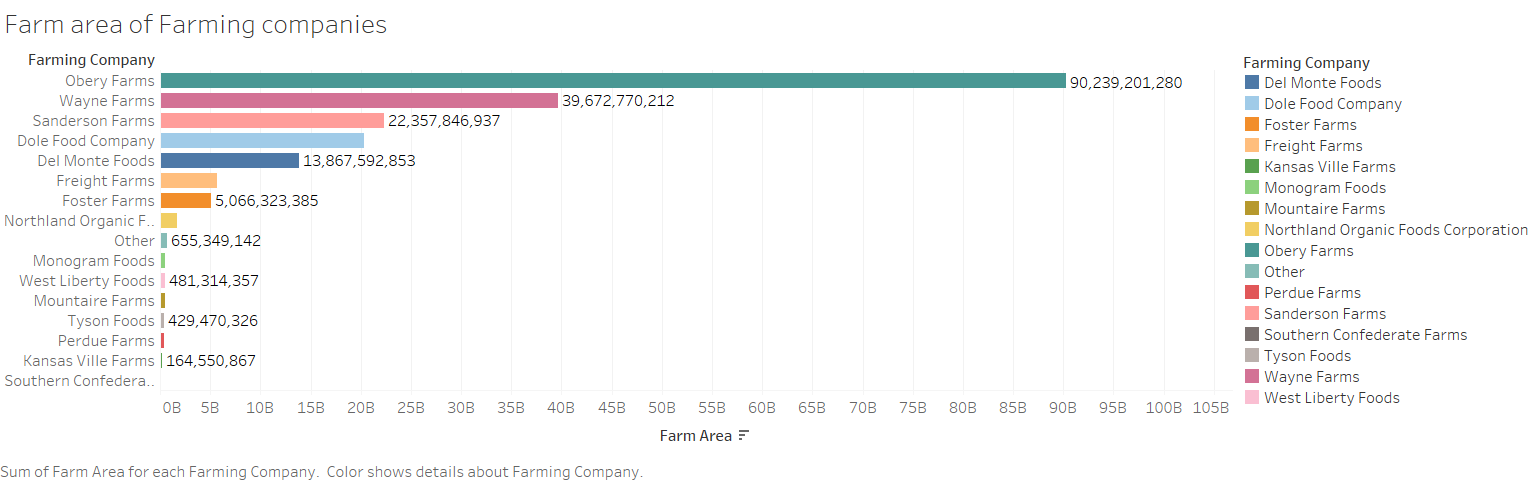

In [9]:
Image(r'C:\Users\Raj\OneDrive\Desktop\PHD\Tablue\Sheet 7.png')

#### Obsevation
* Obey farms having more farm area compared to other farming companies that is the reason yield of obey farms is high.

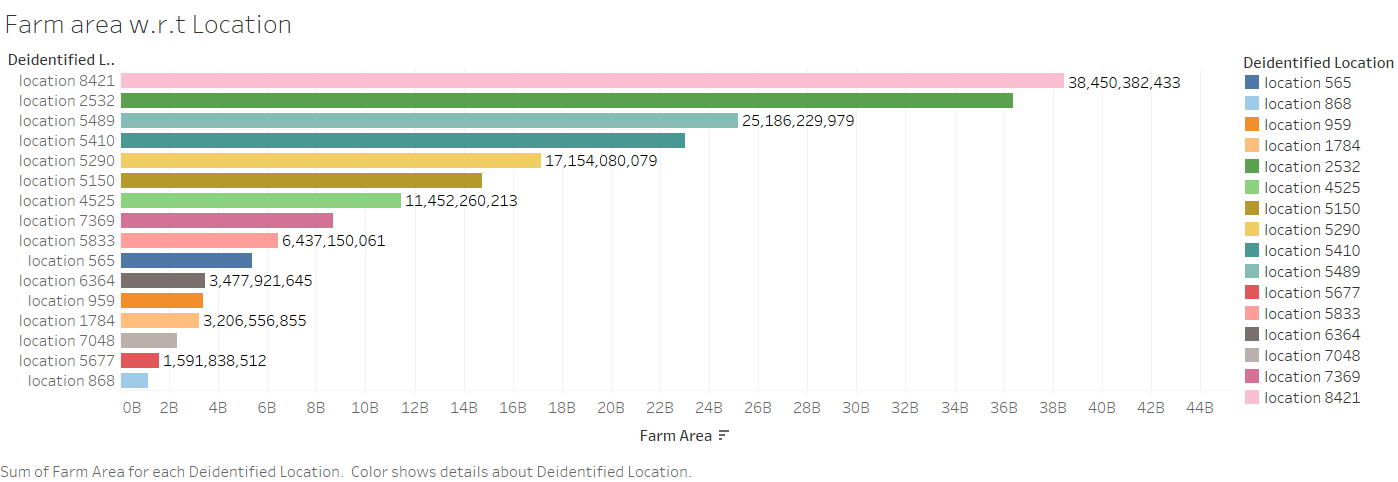

In [10]:
Image(r'C:\Users\Raj\OneDrive\Desktop\PHD\Tablue\Sheet 8.png')

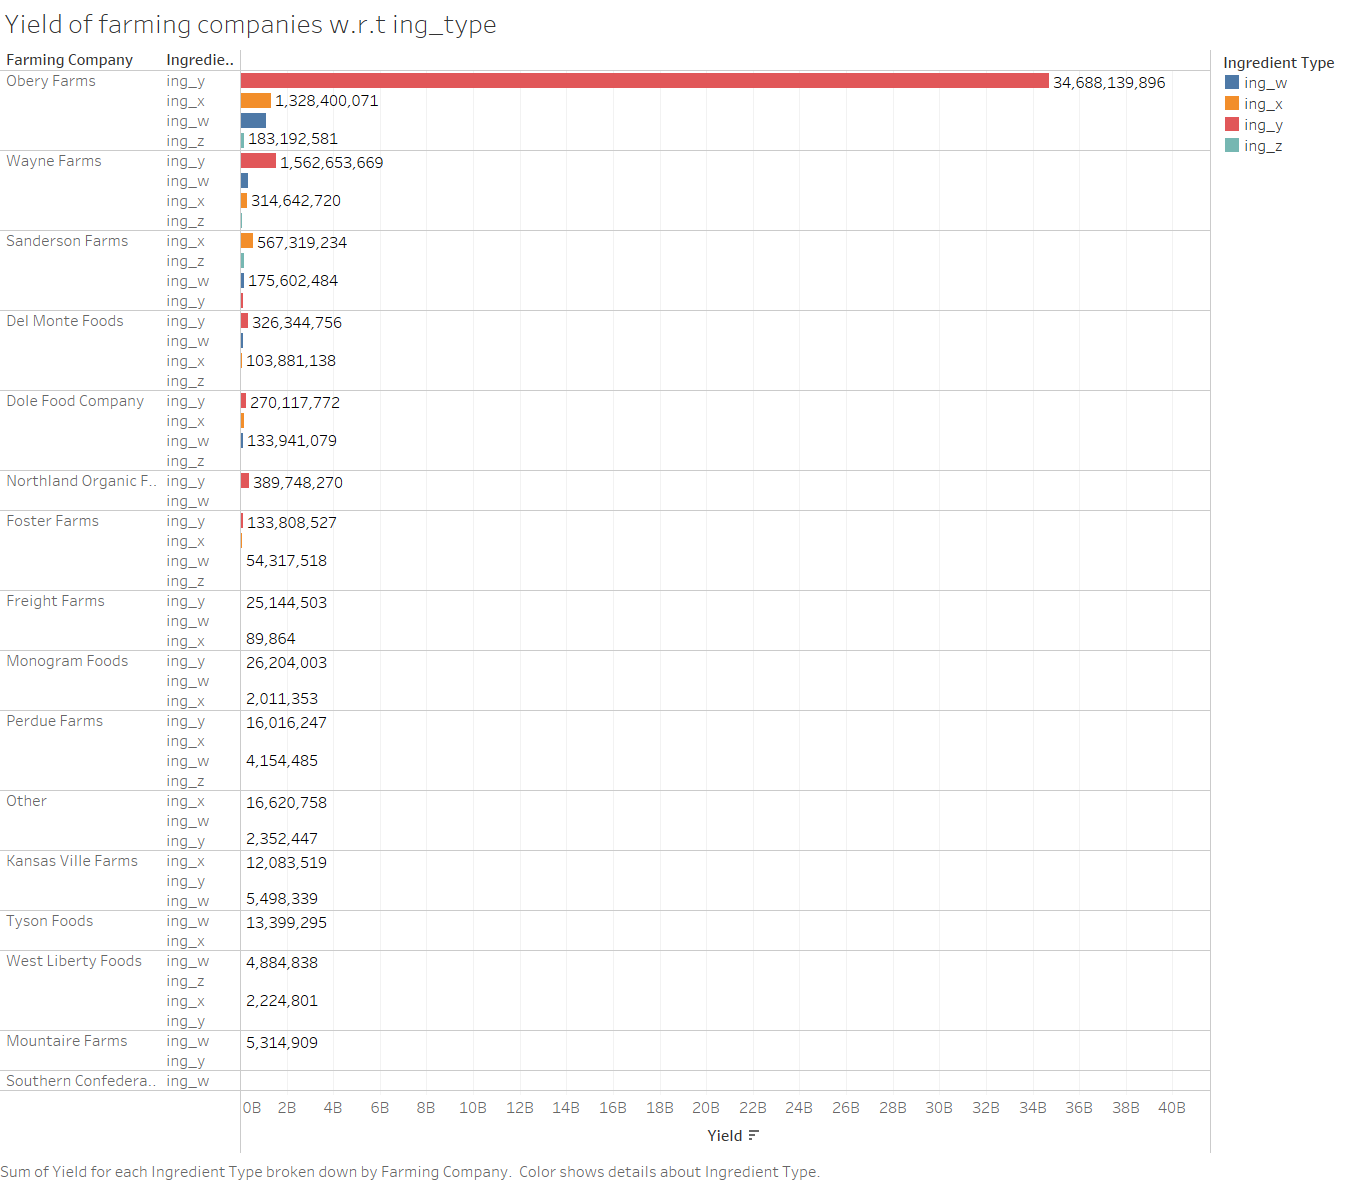

In [11]:
Image(r'C:\Users\Raj\OneDrive\Desktop\PHD\Tablue\Sheet 9.png')

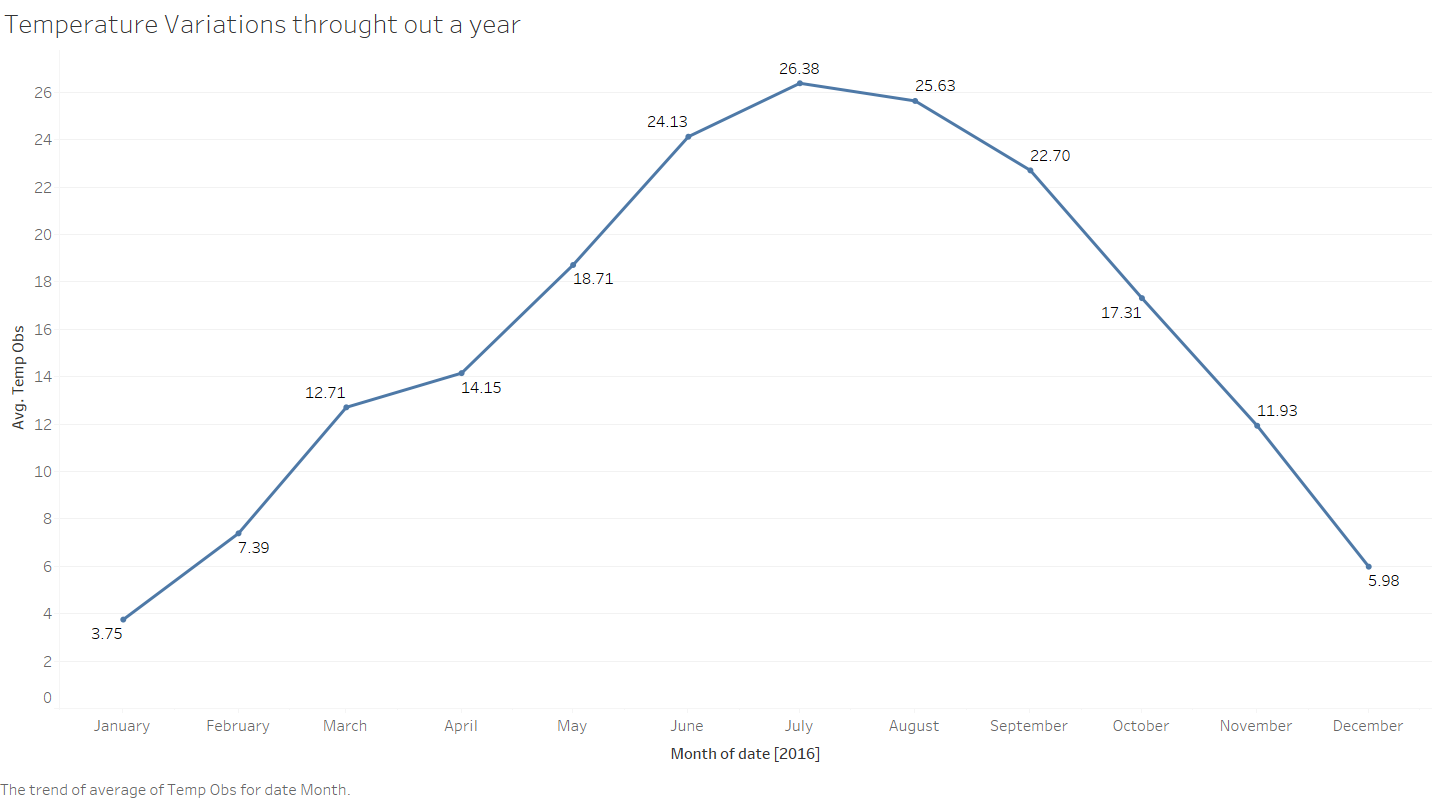

In [12]:
Image(r'C:\Users\Raj\OneDrive\Desktop\PHD\Tablue\Sheet 10.png')

#### Obsevation
* High Temperature in the months of June to September

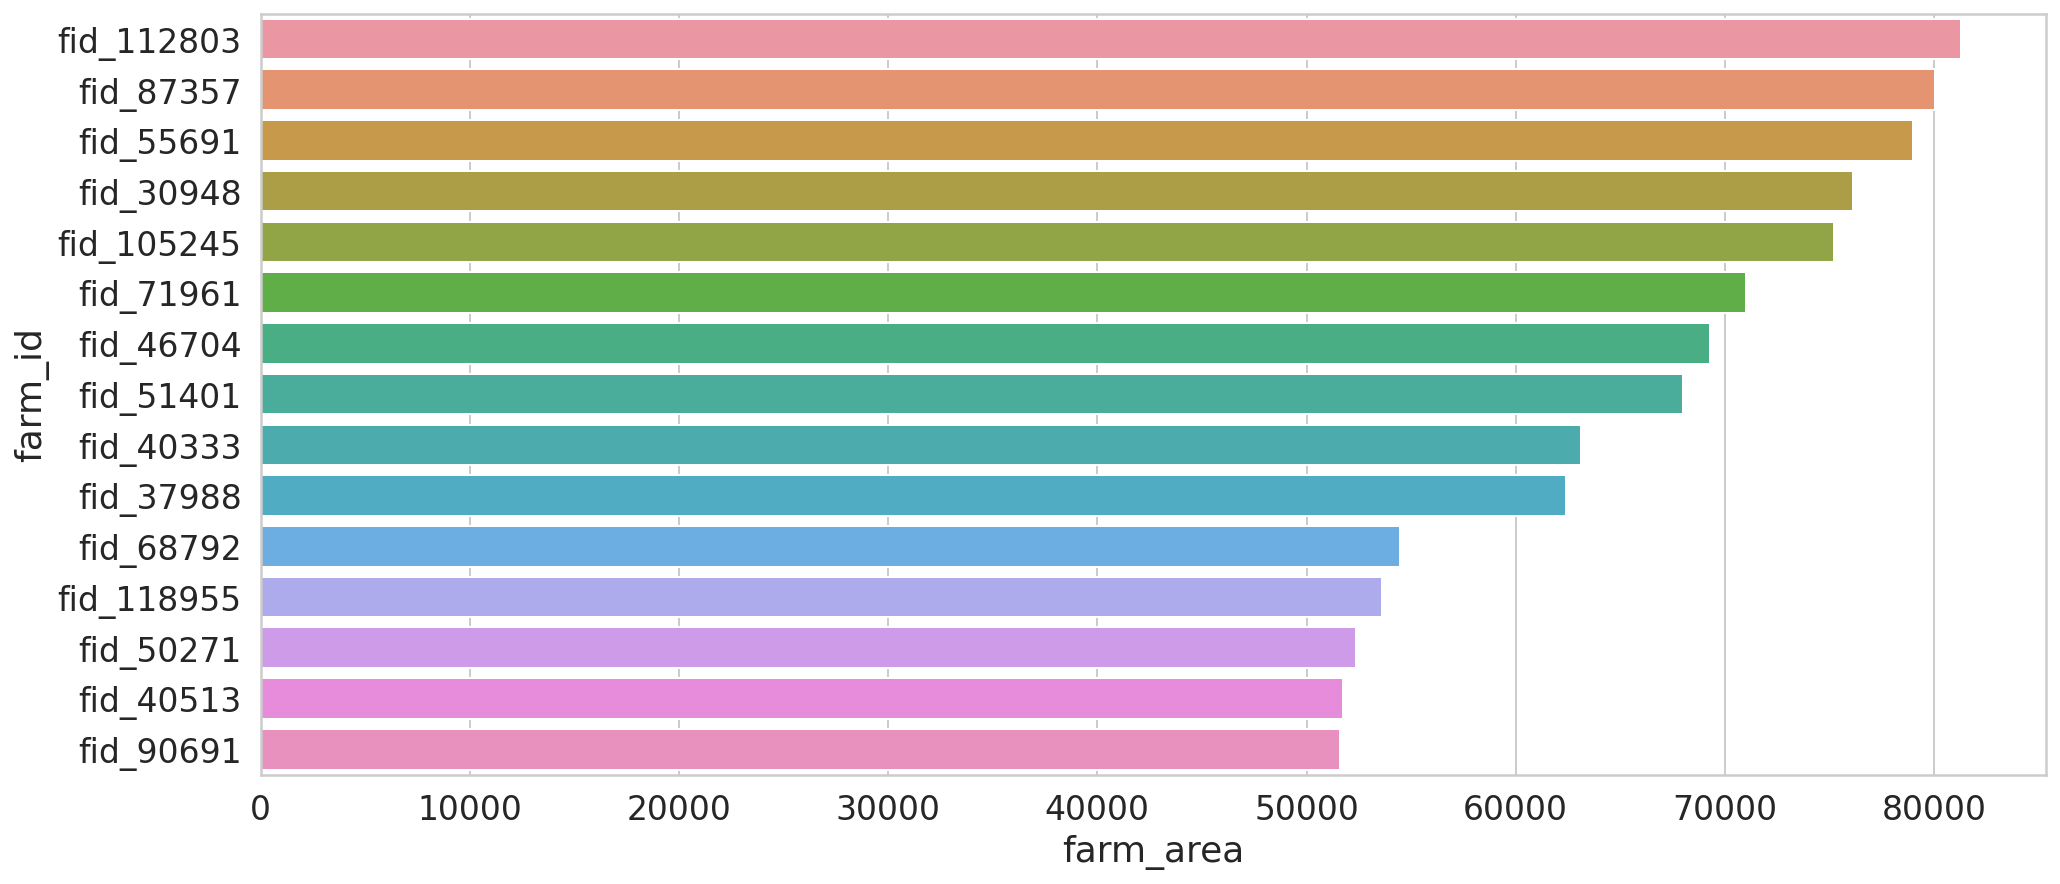

In [27]:
#Top15 forms with more area
data_farm = (farm_data.groupby('farm_id').agg({'farm_area':'sum'}))
data_farm = data_farm.sort_values('farm_area',ascending=False)[0:15]
sns.barplot(y=data_farm.index,x=data_farm["farm_area"])


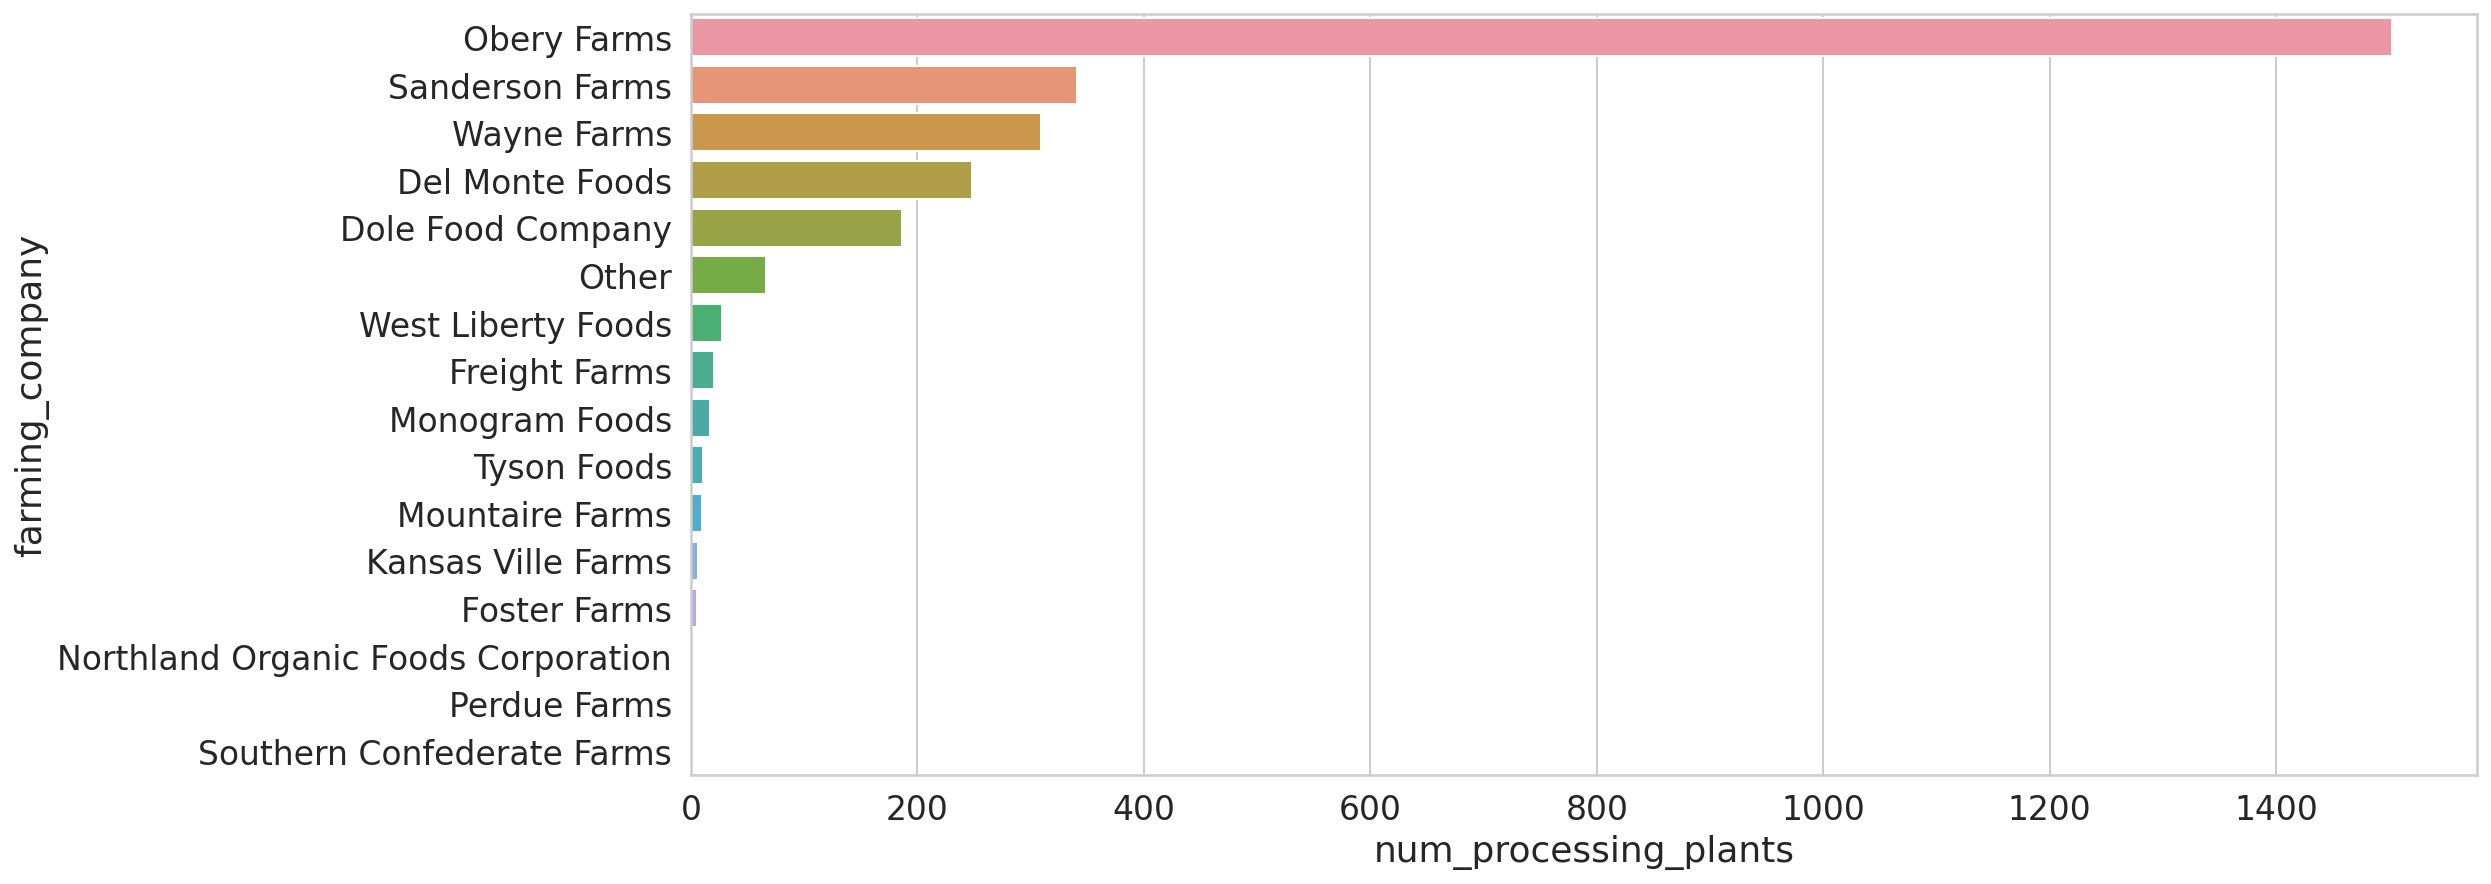

In [55]:
#Framing companies with more no. of Processing plants
data_comp = (farm_data.groupby('farming_company').agg({'num_processing_plants':'sum'}))
data_comp = data_comp.sort_values('num_processing_plants',ascending=False)
sns.barplot(y=data_comp.index,x=data_comp["num_processing_plants"])



In [29]:
train_weather.head()

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
0,2016-01-01 00:00:00,location 7369,25.0,6.0,0.0,20.0,1019.7,NaN,0.0
1,2016-01-01 01:00:00,location 7369,24.4,NaN,70.0,21.1,1020.2,-1.0,1.5
2,2016-01-01 02:00:00,location 7369,22.8,2.0,0.0,21.1,1020.2,0.0,0.0
3,2016-01-01 03:00:00,location 7369,21.1,2.0,0.0,20.6,1020.1,0.0,0.0
4,2016-01-01 04:00:00,location 7369,20.0,2.0,250.0,20.0,1020.0,-1.0,2.6


In [27]:
train_weather["month"] = pd.to_datetime(train_weather["timestamp"], format = '%Y-%m-%d %H:%M:%S').dt.month
train_weather["hour"] = pd.to_datetime(train_weather["timestamp"], format = '%Y-%m-%d %H:%M:%S').dt.hour

In [28]:
train_weather.head()

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,month,hour
0,2016-01-01 00:00:00,location 7369,25.0,6.0,0.0,20.0,1019.7,NaN,0.0,1,0
1,2016-01-01 01:00:00,location 7369,24.4,NaN,70.0,21.1,1020.2,-1.0,1.5,1,1
2,2016-01-01 02:00:00,location 7369,22.8,2.0,0.0,21.1,1020.2,0.0,0.0,1,2
3,2016-01-01 03:00:00,location 7369,21.1,2.0,0.0,20.6,1020.1,0.0,0.0,1,3
4,2016-01-01 04:00:00,location 7369,20.0,2.0,250.0,20.0,1020.0,-1.0,2.6,1,4


<AxesSubplot:xlabel='month', ylabel='cloudiness'>

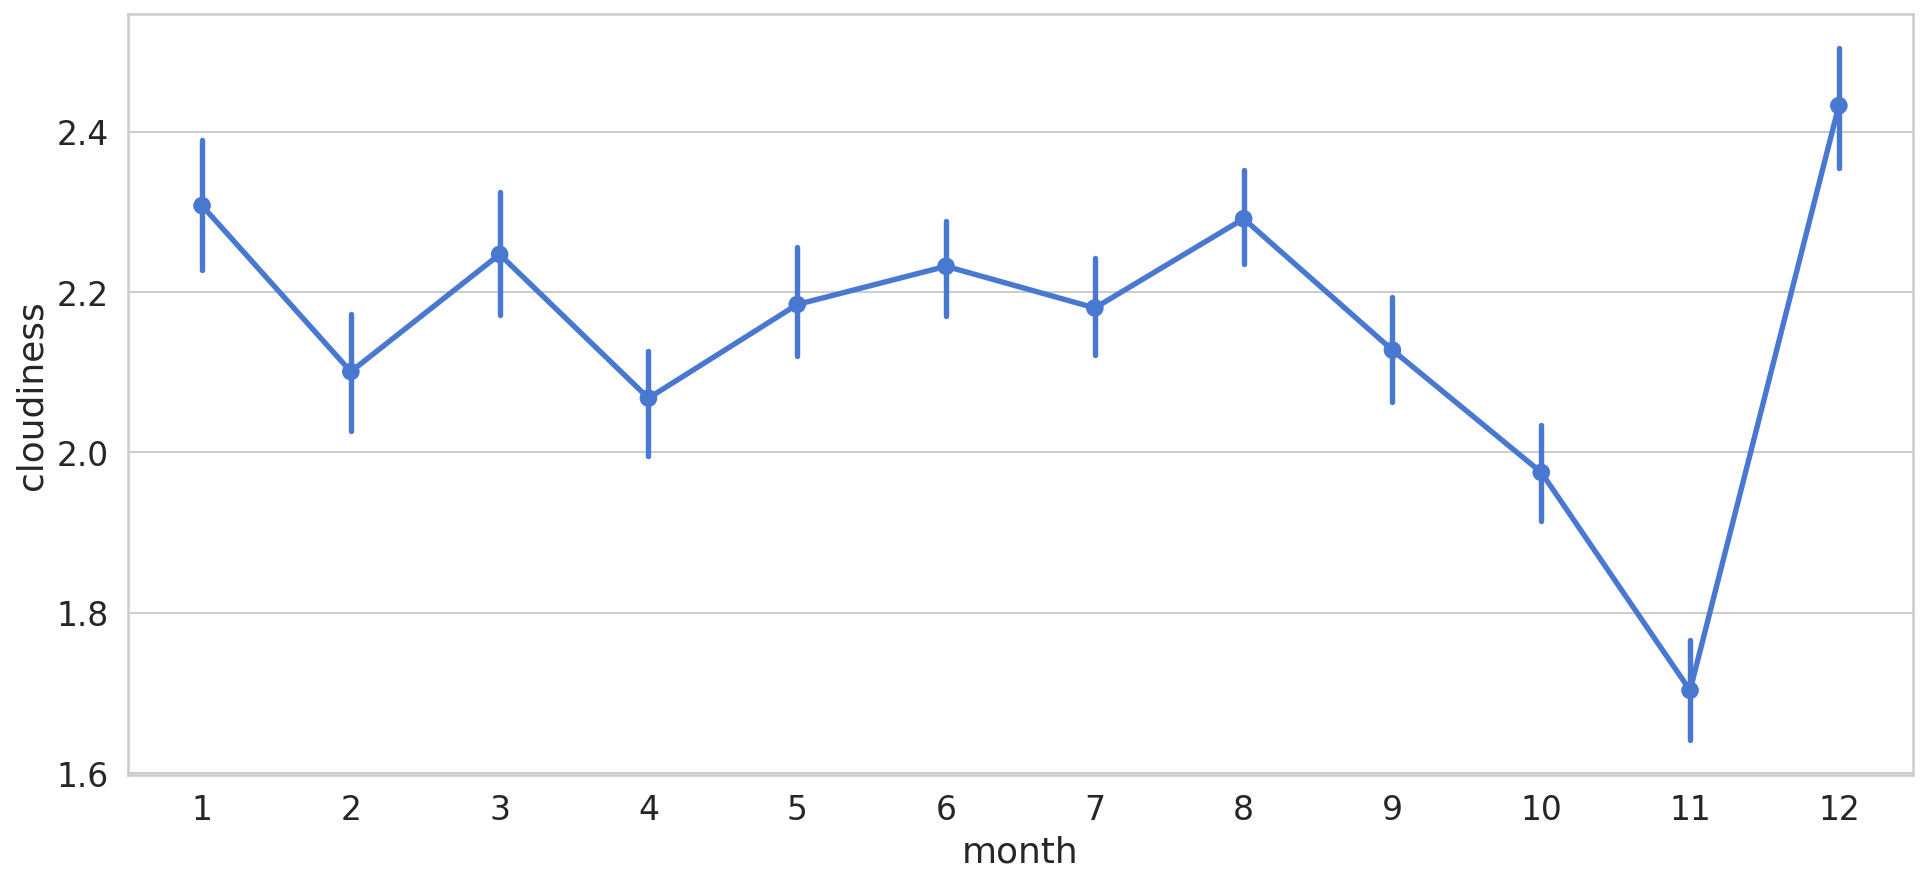

In [ ]:
sns.pointplot(x=train_weather.month, y='cloudiness', data= train_weather)

#### Observation
* Seems like rainfall is almost constant from Janaury to August But sudden drop in November.

<AxesSubplot:xlabel='month', ylabel='pressure_sea_level'>

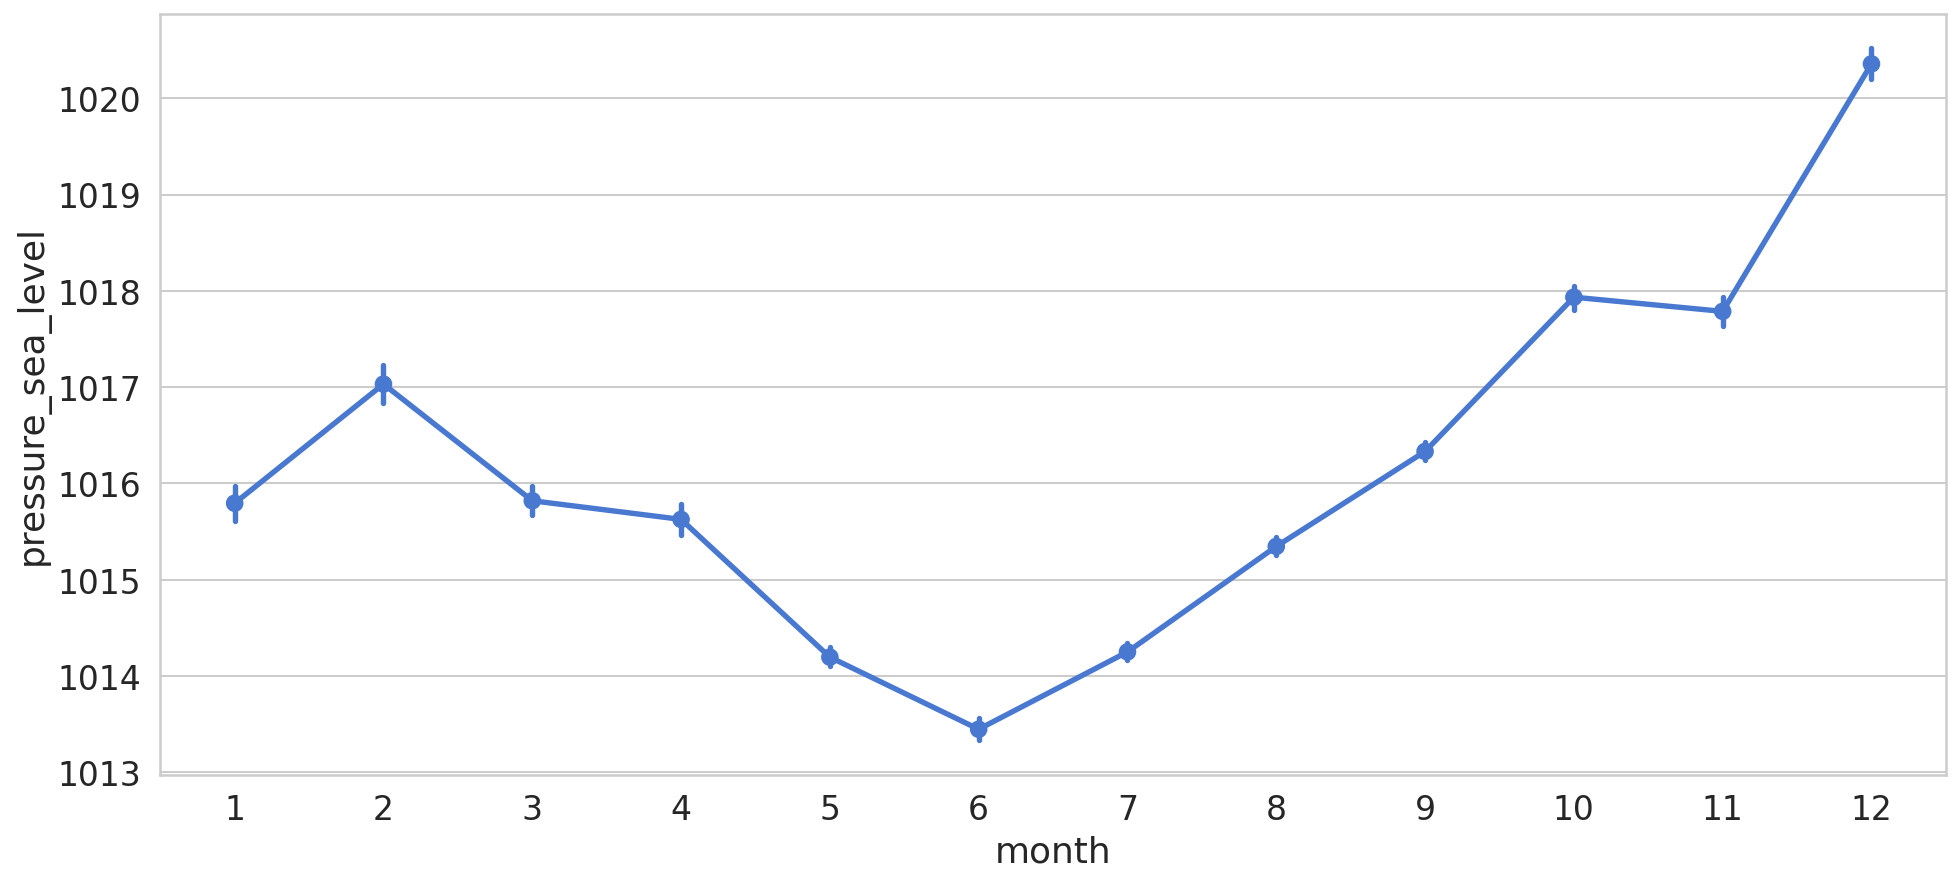

In [ ]:
sns.pointplot(x=train_weather.month, y='pressure_sea_level', data= train_weather)

#### Observation
* Lower Atmospheric pressure in the months April to july at the same we getting more yields in these months

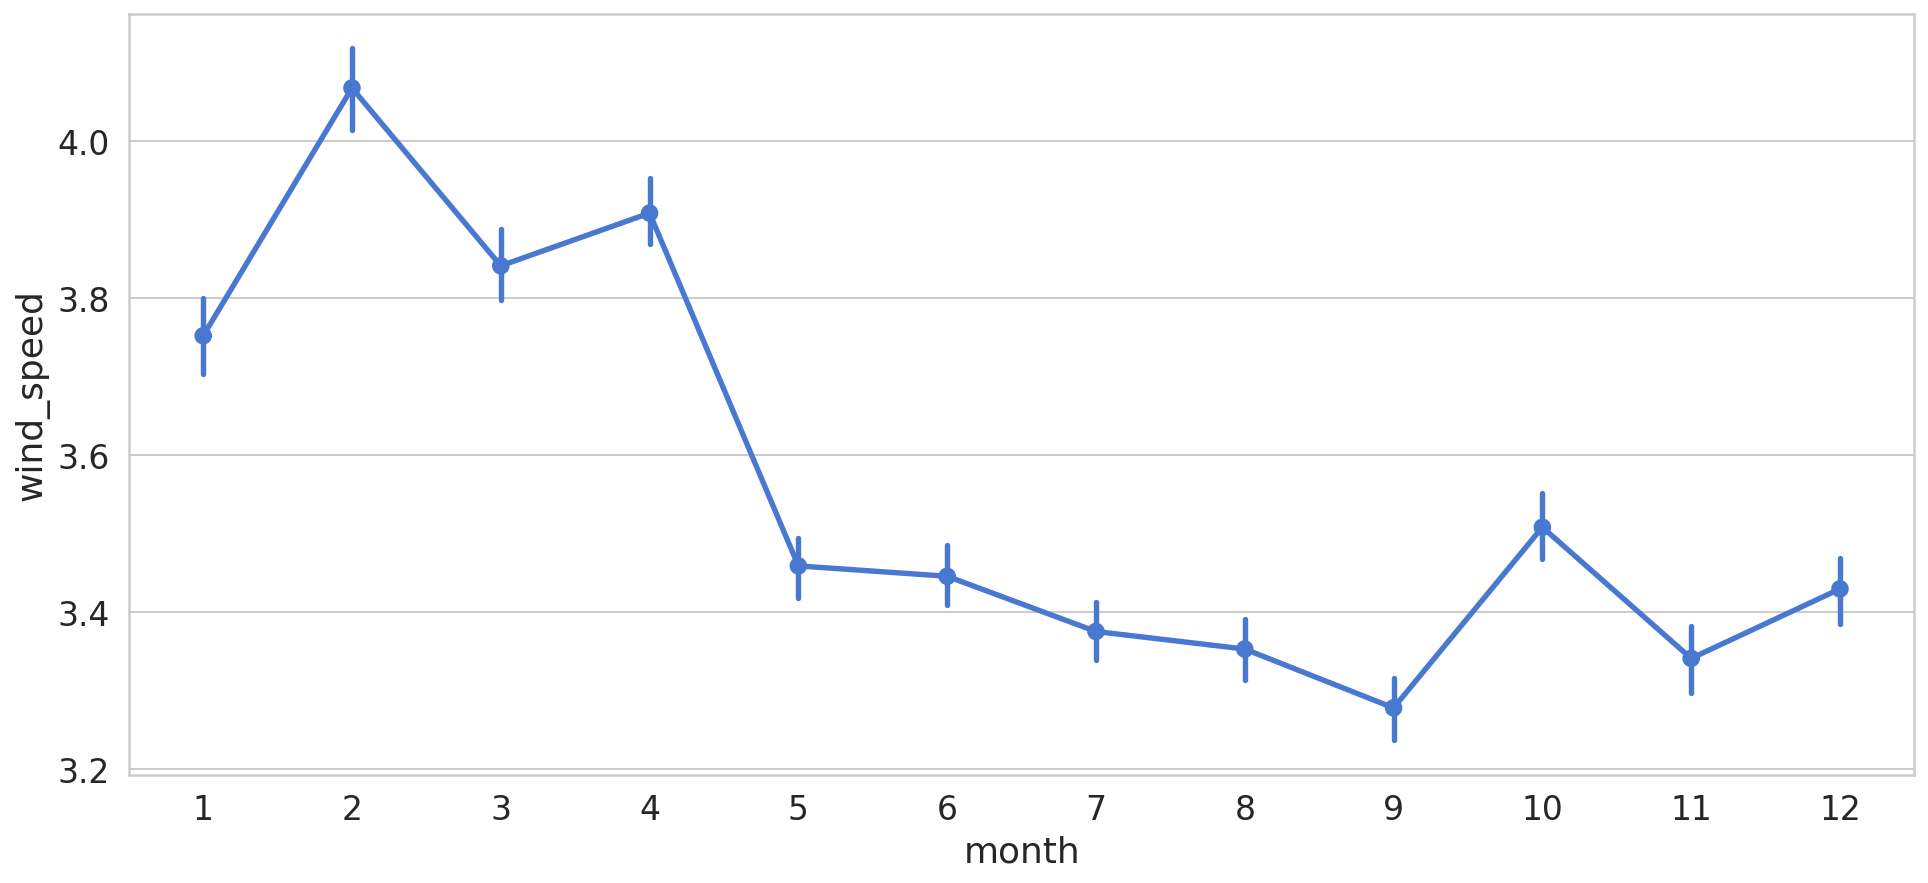

In [31]:
sns.pointplot(x=train_weather.month, y='wind_speed', data= train_weather)

#### Meging all Dataframes

* Before Merging Data frames remove unnecessary features

* In farm_data drop features "operations_commencing_year" and "num_processing_plants" due high missing values
* In train_weather drop features "cloudiness" and "precipitation" due high missing values

In [29]:
farm_data.drop(['operations_commencing_year','num_processing_plants'],axis=1,inplace=True)

In [30]:
train_weather.drop(['cloudiness','precipitation','month','hour'],axis=1,inplace=True)

In [31]:
#checking for duplicates
print(train_data.duplicated().sum())
print(farm_data.duplicated().sum())
print(train_weather.duplicated().sum())


0
0
0


In [32]:
print(train_data.shape)
print(farm_data.shape)
print(train_weather.shape)

(20215983, 7)
(1449, 4)
(139773, 7)


In [33]:
train_weather = train_weather.rename(columns={"timestamp":"date"})

In [34]:
train_weather["date"] = pd.to_datetime(train_weather["date"], format = '%Y-%m-%d %H:%M:%S')

In [35]:
data = pd.merge(train_data,farm_data,how='left',on='farm_id')
data = pd.merge(data,train_weather,how='left',on=['date','deidentified_location'] )

In [36]:
data.head()

,date,farm_id,ingredient_type,yield,month,Day,Hour,farm_area,farming_company,deidentified_location,temp_obs,wind_direction,dew_temp,pressure_sea_level,wind_speed
0,2016-01-01,fid_110884,ing_w,0.0,1,1,0,690.455096,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,0.0
1,2016-01-01,fid_90053,ing_w,0.0,1,1,0,252.696160,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,0.0
2,2016-01-01,fid_17537,ing_w,0.0,1,1,0,499.446528,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,0.0
3,2016-01-01,fid_110392,ing_w,0.0,1,1,0,2200.407555,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,0.0
4,2016-01-01,fid_62402,ing_w,0.0,1,1,0,10833.140121,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,0.0


In [37]:
data_dup = data.duplicated(['date', 'farm_id', 'ingredient_type', 'yield'])
len(data_dup)

20602665

In [38]:
ind_dup = [i for i, x in enumerate(data_dup) if x]
data = data.drop(ind_dup,axis=0)

In [39]:
data.shape

(20215983, 15)

In [40]:
understand_data(data)

,Datatype,No of NAs,No of Levels,Levels
date,datetime64[ns],0,8784,['2016-01-01T00:00:00.000000000' '2016-01-01T0...
farm_id,object,0,1434,['fid_110884' 'fid_90053' 'fid_17537' ... 'fid...
ingredient_type,object,0,4,['ing_w' 'ing_z' 'ing_x' 'ing_y']
yield,float64,0,1688175,[ 0. 53.2397 43.0013 ... 3006.82 ...
month,int64,0,12,[ 1 2 3 4 5 6 7 8 9 10 11 12]
Day,int64,0,31,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
Hour,int64,0,24,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
farm_area,float64,0,1382,[ 690.455096 252.69616 499.446528 ... 5...
farming_company,object,0,16,['Obery Farms' 'Dole Food Company' 'Wayne Farm...
deidentified_location,object,0,16,['location 7369' 'location 959' 'location 5489...


In [41]:
data.columns

Index(['date', 'farm_id', 'ingredient_type', 'yield', 'month', 'Day', 'Hour',
       'farm_area', 'farming_company', 'deidentified_location', 'temp_obs',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'wind_speed'],
      dtype='object')

In [42]:
data.shape

(20215983, 15)

In [43]:
#data.to_csv("/content/drive/MyDrive/PHD/Final_train.csv",index=False)

In [3]:
data = pd.read_csv("Final_train.csv")

In [4]:
data.shape

(20215983, 15)

In [5]:
understand_data(data)

,Datatype,No of NAs,No of Levels,Levels
date,object,0,8784,['2016-01-01 00:00:00' '2016-01-01 01:00:00' '...
farm_id,object,0,1434,['fid_110884' 'fid_90053' 'fid_17537' ... 'fid...
ingredient_type,object,0,4,['ing_w' 'ing_z' 'ing_x' 'ing_y']
yield,float64,0,1688175,[ 0. 53.2397 43.0013 ... 3006.82 ...
month,int64,0,12,[ 1 2 3 4 5 6 7 8 9 10 11 12]
Day,int64,0,31,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
Hour,int64,0,24,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
farm_area,float64,0,1382,[ 690.455096 252.69616 499.446528 ... 5...
farming_company,object,0,16,['Obery Farms' 'Dole Food Company' 'Wayne Farm...
deidentified_location,object,0,16,['location 7369' 'location 959' 'location 5489...


In [6]:
# Encoding the farm_id column by using Mean Encoding
farm_en = data.groupby(['farm_id'])['yield'].mean().to_dict()  
data['farm_id'] =  data['farm_id'].map(farm_en)

In [7]:
cat_attr = ["ingredient_type","farming_company","deidentified_location"]
data[cat_attr] = data[cat_attr].astype("category")

In [8]:
# train-test split shouldn't be done randomly like for other types of problems. Sequentiality should be preserved for time series data.
train_size = int(len(data) * 0.9)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(len(train), len(test))

18194384 2021599


In [9]:
train.head()

,date,farm_id,ingredient_type,yield,month,Day,Hour,farm_area,farming_company,deidentified_location,temp_obs,wind_direction,dew_temp,pressure_sea_level,wind_speed
0,2016-01-01 00:00:00,146.454978,ing_w,0.0,1,1,0,690.455096,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,0.0
1,2016-01-01 00:00:00,74.865393,ing_w,0.0,1,1,0,252.696160,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,0.0
2,2016-01-01 00:00:00,14.551385,ing_w,0.0,1,1,0,499.446528,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,0.0
3,2016-01-01 00:00:00,235.549966,ing_w,0.0,1,1,0,2200.407555,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,0.0
4,2016-01-01 00:00:00,976.556746,ing_w,0.0,1,1,0,10833.140121,Obery Farms,location 7369,25.0,0.0,20.0,1019.7,0.0


In [10]:
# Memory optimization function
def data_optimize(df, object_option=False):
    """Reduce the size of the input dataframe
    Parameters
    ----------
    df: pd.DataFrame
        input DataFrame
    object_option : bool, default=False
        if true, try to convert object to category
    Returns
    -------
    df: pd.DataFrame
        data type optimized output dataframe
    """

    # loop columns in the dataframe to downcast the dtype
    for col in df.columns:
        # process the int columns
        if df[col].dtype == 'int':
            col_min = df[col].min()
            col_max = df[col].max()
            # if all are non-negative, change to uint
            if col_min >= 0:
                if col_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif col_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif col_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col]
            else:
                # if it has negative values, downcast based on the min and max
                if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                    df[col] = df[col].astype(np.int8)
                elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                    df[col] = df[col].astype(np.int16)
                elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col]
                    
        # process the float columns
        elif df[col].dtype == 'float':
            col_min = df[col].min()
            col_max = df[col].max()
            # downcast based on the min and max
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col]

        if object_option:
            if df[col].dtype == 'object':
                if len(df[col].value_counts()) < 0.5 * df.shape[0]:
                    df[col] = df[col].astype('category')

    return df

In [11]:
train = data_optimize(train)
test = data_optimize(test)

In [12]:
#train.to_csv("/content/drive/MyDrive/PHD/train.csv",index=False)
#test.to_csv("/content/drive/MyDrive/PHD/test.csv",index=False)

In [13]:
X_train = train.drop(['yield','date'],axis=1)
y_train = train['yield']
X_test = test.drop(['yield','date'],axis=1)
y_test = test['yield']

In [14]:
X_train.head()

,farm_id,ingredient_type,month,Day,Hour,farm_area,farming_company,deidentified_location,temp_obs,wind_direction,dew_temp,pressure_sea_level,wind_speed
0,146.454971,ing_w,1,1,0,690.455078,Obery Farms,location 7369,25.0,0.0,20.0,1019.700012,0.0
1,74.865395,ing_w,1,1,0,252.696167,Obery Farms,location 7369,25.0,0.0,20.0,1019.700012,0.0
2,14.551385,ing_w,1,1,0,499.446533,Obery Farms,location 7369,25.0,0.0,20.0,1019.700012,0.0
3,235.549973,ing_w,1,1,0,2200.407471,Obery Farms,location 7369,25.0,0.0,20.0,1019.700012,0.0
4,976.556763,ing_w,1,1,0,10833.139648,Obery Farms,location 7369,25.0,0.0,20.0,1019.700012,0.0


In [15]:
categorical_list = ['ingredient_type','farming_company','deidentified_location']
numeric_list = ['farm_id','farm_area','temp_obs',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'wind_speed']

In [16]:
X_train = data_optimize(X_train)
X_test = data_optimize(X_test)

In [17]:
X_train = pd.get_dummies(columns=categorical_list,data = X_train)
X_test = pd.get_dummies(columns=categorical_list,data = X_test)

In [18]:
imputer = SimpleImputer(strategy='mean')
imputer = imputer.fit(X_train[numeric_list])


In [19]:
X_train[numeric_list] = imputer.transform(X_train[numeric_list])
X_test[numeric_list] = imputer.transform(X_test[numeric_list])

In [20]:
scaler = RobustScaler()
scaler.fit(X_train[numeric_list])

RobustScaler()

In [21]:
X_train[numeric_list] = scaler.transform(X_train[numeric_list])
X_test[numeric_list] = scaler.transform(X_test[numeric_list])

In [22]:
X_train.head()

,farm_id,month,Day,Hour,farm_area,temp_obs,wind_direction,dew_temp,pressure_sea_level,wind_speed,...,deidentified_location_location 5489,deidentified_location_location 565,deidentified_location_location 5677,deidentified_location_location 5833,deidentified_location_location 6364,deidentified_location_location 7048,deidentified_location_location 7369,deidentified_location_location 8421,deidentified_location_location 868,deidentified_location_location 959
0,0.011818,1,1,0,-0.608109,0.48,-0.905886,0.653846,0.489097,-1.24,...,0,0,0,0,0,0,1,0,0,0
1,-0.206367,1,1,0,-0.652418,0.48,-0.905886,0.653846,0.489097,-1.24,...,0,0,0,0,0,0,1,0,0,0
2,-0.390186,1,1,0,-0.627442,0.48,-0.905886,0.653846,0.489097,-1.24,...,0,0,0,0,0,0,1,0,0,0
3,0.283354,1,1,0,-0.455278,0.48,-0.905886,0.653846,0.489097,-1.24,...,0,0,0,0,0,0,1,0,0,0
4,2.541732,1,1,0,0.418492,0.48,-0.905886,0.653846,0.489097,-1.24,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
gbr1 = GradientBoostingRegressor(learning_rate=0.01, max_depth=7, n_estimators=1000)
gbr1.fit(X_train, y_train)

In [ ]:
import pickle
Pkl_Filename = r"GBR.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(gbr1, file)